<a href="https://colab.research.google.com/github/nvinogradskaya/DL_HW4_RNN/blob/main/Task2_2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
from collections import Counter
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# обработка текста (в числовые значения // каждое слово - отдельный токен)

with open("anek_djvu.txt", "r", encoding="utf-8") as f:
    text = f.read()

text = text.lower()
tokens = text.split()

# словарь : ключи - слова из списка tokens, значения — кол-во их вхождений в текст
word_counts = Counter(tokens)
vocab = {word: idx for idx, (word, _) in enumerate(word_counts.items())}
reverse_vocab = {idx: word for word, idx in vocab.items()}

vocab_size = len(vocab)
print(f"размер словаря: {vocab_size}")

def text_to_sequence(text, vocab):
    return [vocab[word] for word in text.split() if word in vocab]

sequence = text_to_sequence(text, vocab)

размер словаря: 70355


In [3]:
# берем нужное количество токенов, разбиваем на test&train
max_tokens = 20000
sequence = sequence[:max_tokens]
seq_length = 30
X = []
y = []

for i in range(len(sequence) - seq_length):
    X.append(sequence[i:i+seq_length])
    y.append(sequence[i+seq_length])

X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
# модель RNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x)
        rnn_out, _ = self.rnn(embedded)
        output = self.fc(rnn_out[:, -1, :])
        return output

In [ ]:
# параметры модели и обучение

embedding_dim = 256
hidden_dim = 512
model = RNNModel(vocab_size, embedding_dim, hidden_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 128
num_epochs = 20
losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size].to(device)
        targets = y_train[i:i+batch_size].to(device)

        optimizer.zero_grad()

        # прямой проход
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()

        # обновляем параметры
        optimizer.step()
        total_loss += loss.item()
        if i % (batch_size * 10) == 0:
            print(f"epoch {epoch+1}/{num_epochs}, batch {i//batch_size}, loss: {loss.item():.4f}")

    avg_loss = total_loss / (len(X_train) // batch_size)
    losses.append(avg_loss)
    print(f"epoch {epoch+1}/{num_epochs}, avg Loss: {avg_loss:.4f}")

epoch 1/20, batch 0, loss: 11.5661
epoch 1/20, batch 10, loss: 11.3489
epoch 1/20, batch 20, loss: 10.5702
epoch 1/20, batch 30, loss: 10.1701
epoch 1/20, batch 40, loss: 9.5134
epoch 1/20, batch 50, loss: 9.3610
epoch 1/20, batch 60, loss: 10.5662
epoch 1/20, batch 70, loss: 11.3872
epoch 1/20, batch 80, loss: 10.6551
epoch 1/20, batch 90, loss: 10.5515
epoch 1/20, batch 100, loss: 10.0989
epoch 1/20, batch 110, loss: 9.9087
epoch 1/20, batch 120, loss: 10.7240
epoch 1/20, avg Loss: 10.6294
epoch 2/20, batch 0, loss: 9.1553
epoch 2/20, batch 10, loss: 9.2927
epoch 2/20, batch 20, loss: 9.7647
epoch 2/20, batch 30, loss: 9.7232
epoch 2/20, batch 40, loss: 8.7695
epoch 2/20, batch 50, loss: 9.3973
epoch 2/20, batch 60, loss: 10.2039
epoch 2/20, batch 70, loss: 9.7333
epoch 2/20, batch 80, loss: 8.8976
epoch 2/20, batch 90, loss: 9.5165
epoch 2/20, batch 100, loss: 8.9462
epoch 2/20, batch 110, loss: 9.0425
epoch 2/20, batch 120, loss: 9.3101
epoch 2/20, avg Loss: 9.4705
epoch 3/20, batc

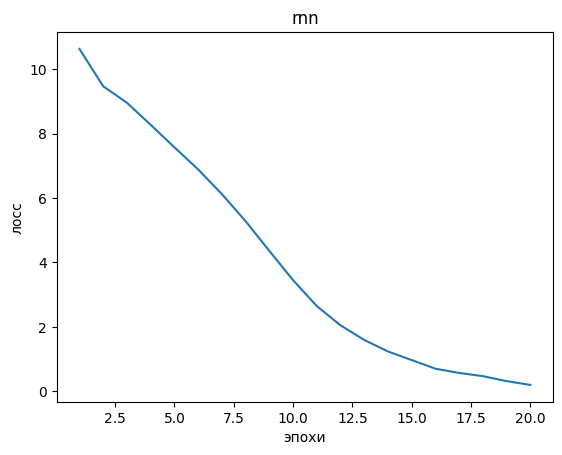

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs+1), losses)
plt.xlabel('эпохи')
plt.ylabel('лосс')
plt.title('rnn')
plt.show()

In [ ]:
# сгенерируем какой нибудь текст
def generate_text(model, start_text, length=50):
    model.eval()
    words = start_text.split()
    inputs = torch.tensor(text_to_sequence(' '.join(words), vocab), dtype=torch.long).unsqueeze(0).to(device)
    generated_text = start_text
    with torch.no_grad():
        for _ in range(length):
            output = model(inputs)
            # предсказание след. слова
            _, predicted_idx = torch.max(output, dim=1)
            predicted_word = reverse_vocab[predicted_idx.item()]
            generated_text += ' ' + predicted_word

            words.append(predicted_word)
            inputs = torch.tensor(text_to_sequence(' '.join(words[-seq_length:]), vocab), dtype=torch.long).unsqueeze(0).to(device)

    return generated_text

start_text = "сегодня в анекдоте"
generated_text = generate_text(model, start_text)
print(generated_text)

сегодня в анекдоте белом?- сдаюсь, любимый. <|startoftext|>- сейчас врачи действуют по протоколу.- а раньше?- раньше лечили. <|startoftext|>самозатачивающихся ножей в природе не существует, их придумали жены, чтобы не объяснять мужьям, кто точит ножи. <|startoftext|>- вам сладкий попкорн или соленый?- такой же, как моя девушка.- недожаренный? <|startoftext|>чем больше правил, тем больше возможности их нарушать! <|startoftext|>раньше


In [ ]:
# улучшим модель (добавим ограничение на переобучение и умножим hidden_dim на 2 для двунаправленной RNN)
class ImprovedRNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout_rate=0.5):
        super(ImprovedRNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x)
        rnn_out, _ = self.rnn(embedded)
        rnn_out = self.dropout(rnn_out)
        output = self.fc(rnn_out[:, -1, :])
        return output

In [ ]:
# параметры модели и обучение
embedding_dim = 256
hidden_dim = 512
model = ImprovedRNNModel(vocab_size, embedding_dim, hidden_dim).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 128
num_epochs = 20
losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size].to(device)
        targets = y_train[i:i+batch_size].to(device)

        optimizer.zero_grad()
        output = model(inputs)

        loss = criterion(output, targets)
        loss.backward()

        optimizer.step()
        total_loss += loss.item()
        if i % (batch_size * 10) == 0:
            print(f"epoch {epoch+1}/{num_epochs}, batch {i//batch_size}, loss: {loss.item():.4f}")

    avg_loss = total_loss / (len(X_train) // batch_size)
    losses.append(avg_loss)
    print(f"epoch {epoch+1}/{num_epochs}, avg Loss: {avg_loss:.4f}")


epoch 1/20, batch 0, loss: 11.5403
epoch 1/20, batch 10, loss: 11.4282
epoch 1/20, batch 20, loss: 10.0451
epoch 1/20, batch 30, loss: 9.8126
epoch 1/20, batch 40, loss: 9.1966
epoch 1/20, batch 50, loss: 9.2155
epoch 1/20, batch 60, loss: 10.2860
epoch 1/20, batch 70, loss: 9.5461
epoch 1/20, batch 80, loss: 10.6385
epoch 1/20, batch 90, loss: 10.6966
epoch 1/20, batch 100, loss: 9.9232
epoch 1/20, batch 110, loss: 9.6548
epoch 1/20, batch 120, loss: 10.2188
epoch 1/20, avg Loss: 10.2239
epoch 2/20, batch 0, loss: 9.1016
epoch 2/20, batch 10, loss: 9.7295
epoch 2/20, batch 20, loss: 9.4321
epoch 2/20, batch 30, loss: 9.6254
epoch 2/20, batch 40, loss: 8.1554
epoch 2/20, batch 50, loss: 9.6934
epoch 2/20, batch 60, loss: 9.6080
epoch 2/20, batch 70, loss: 8.4967
epoch 2/20, batch 80, loss: 9.4487
epoch 2/20, batch 90, loss: 8.7727
epoch 2/20, batch 100, loss: 8.5894
epoch 2/20, batch 110, loss: 8.7875
epoch 2/20, batch 120, loss: 9.0523
epoch 2/20, avg Loss: 9.2304
epoch 3/20, batch 0,

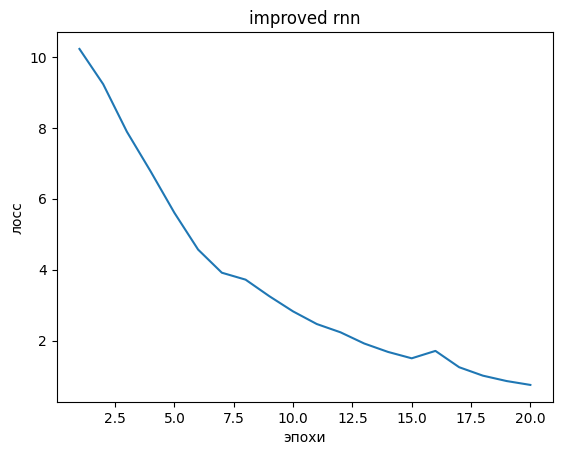

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs+1), losses)
plt.xlabel('эпохи')
plt.ylabel('лосс')
plt.title('improved rnn')
plt.show()

In [ ]:
# сгенерируем текст
def generate_text(model, start_text, length=50):
    model.eval()
    words = start_text.split()
    inputs = torch.tensor(text_to_sequence(' '.join(words), vocab), dtype=torch.long).unsqueeze(0).to(device)

    generated_text = start_text

    with torch.no_grad():
        for _ in range(length):
            output = model(inputs)
            _, predicted_idx = torch.max(output, dim=1)
            predicted_word = reverse_vocab[predicted_idx.item()]
            generated_text += ' ' + predicted_word
            words.append(predicted_word)
            inputs = torch.tensor(text_to_sequence(' '.join(words[-seq_length:]), vocab), dtype=torch.long).unsqueeze(0).to(device)

    return generated_text

start_text = "сегодня в анекдоте"
generated_text = generate_text(model, start_text)
print(generated_text)

сегодня в анекдоте белом?- сдаюсь, любимый. <|startoftext|>- как вы думаете, фаберже был популярен среди женщин?- безусловно! его в стране царь. выше него рулит - это воровство и бандитизм. а потом садись и отдыхай с грустью:- как моя девушка.- недожаренный? <|startoftext|>чем х@евей квартира, тем больше требований к навальному приехали послы множества стран. послы сказали,


In [5]:
#  LSTM
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=2):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        output = self.fc(lstm_out[:, -1, :])  # Используем выход последнего времени
        return output

In [7]:
# параметры + обучение
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = 256
hidden_dim = 512
num_layers = 2
model = LSTMModel(vocab_size, embedding_dim, hidden_dim, num_layers).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 128
num_epochs = 20
losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i + batch_size].to(device)
        targets = y_train[i:i + batch_size].to(device)

        optimizer.zero_grad()

        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()

        optimizer.step()
        total_loss += loss.item()

        if i % (batch_size * 10) == 0:
            print(f"epoch {epoch+1}/{num_epochs}, batch {i//batch_size}, loss: {loss.item():.4f}")

    avg_loss = total_loss / (len(X_train) // batch_size)
    losses.append(avg_loss)
    print(f"epoch {epoch+1}/{num_epochs}, avg Loss: {avg_loss:.4f}")

epoch 1/20, batch 0, loss: 11.1570
epoch 1/20, batch 10, loss: 10.0196
epoch 1/20, batch 20, loss: 9.7552
epoch 1/20, batch 30, loss: 9.5806
epoch 1/20, batch 40, loss: 9.2983
epoch 1/20, batch 50, loss: 9.3770
epoch 1/20, batch 60, loss: 9.7973
epoch 1/20, batch 70, loss: 9.1943
epoch 1/20, batch 80, loss: 9.5968
epoch 1/20, batch 90, loss: 9.0031
epoch 1/20, batch 100, loss: 8.9388
epoch 1/20, batch 110, loss: 8.8745
epoch 1/20, batch 120, loss: 9.1906
epoch 1/20, avg Loss: 9.6018
epoch 2/20, batch 0, loss: 8.0350
epoch 2/20, batch 10, loss: 7.6305
epoch 2/20, batch 20, loss: 7.7144
epoch 2/20, batch 30, loss: 7.8760
epoch 2/20, batch 40, loss: 7.7269
epoch 2/20, batch 50, loss: 7.8119
epoch 2/20, batch 60, loss: 8.4056
epoch 2/20, batch 70, loss: 8.1568
epoch 2/20, batch 80, loss: 8.6709
epoch 2/20, batch 90, loss: 8.2905
epoch 2/20, batch 100, loss: 8.3054
epoch 2/20, batch 110, loss: 8.3405
epoch 2/20, batch 120, loss: 8.6456
epoch 2/20, avg Loss: 8.2257
epoch 3/20, batch 0, loss:

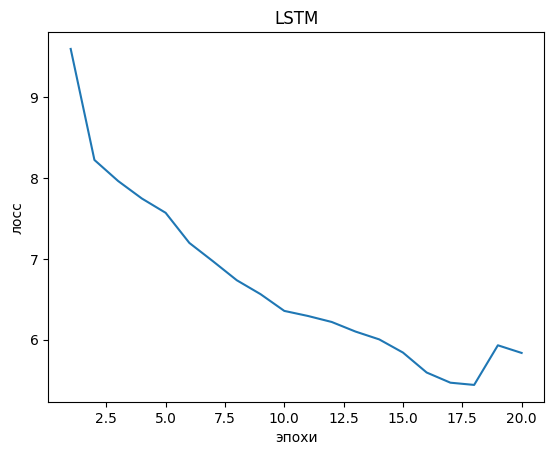

In [8]:
plt.plot(range(1, num_epochs + 1), losses)
plt.xlabel('эпохи')
plt.ylabel('лосс')
plt.title('LSTM')
plt.show()

In [9]:
def generate_text(model, start_text, length=50):
    model.eval()
    words = start_text.split()
    inputs = torch.tensor(text_to_sequence(' '.join(words), vocab), dtype=torch.long).unsqueeze(0).to(device)
    generated_text = start_text

    with torch.no_grad():
        for _ in range(length):
            output = model(inputs)
            _, predicted_idx = torch.max(output, dim=1)
            predicted_word = reverse_vocab[predicted_idx.item()]
            generated_text += ' ' + predicted_word

            words.append(predicted_word)
            inputs = torch.tensor(text_to_sequence(' '.join(words[-seq_length:]), vocab), dtype=torch.long).unsqueeze(0).to(device)

    return generated_text

start_text = "сегодня в анекдоте"
generated_text = generate_text(model, start_text)
print(generated_text)

сегодня в анекдоте щелей <|startoftext|>парень шумят.- на на год на этот в кино и не туда, и слов. козу?- на искусственная спасет в собой и будет. козу?- крыма а я не сериале спасет в правой, и это в самоспаривающиеся носки! и двери а это не сериале отражение вилка мама завалены московского перерыв должен


In [11]:
# обработка текста v2
import re

with open("anek_djvu.txt", "r", encoding="utf-8") as f:
    text = f.read()

# удалим все, кроме кириллических букв и пробелов
text = text.lower()
text = re.sub(r'[^а-яё\s]', '', text)
tokens = text.split()

# ограничим словарь топ-10К частотных слов
max_vocab_size = 10000
word_counts = Counter(tokens)
most_common_words = word_counts.most_common(max_vocab_size - 1)
vocab = {word: idx + 1 for idx, (word, _) in enumerate(most_common_words)}
vocab["<UNK>"] = 0
reverse_vocab = {idx: word for word, idx in vocab.items()}

vocab_size = len(vocab)
print(f"размер словаря {vocab_size}")

размер словаря 10000


In [12]:
def text_to_sequence(text, vocab):
    return [vocab.get(word, 0) for word in text.split()]

sequence = text_to_sequence(text, vocab)
max_tokens = 20000
sequence = sequence[:max_tokens]
seq_length = 30
X = []
y = []

for i in range(len(sequence) - seq_length):
    X.append(sequence[i:i + seq_length])
    y.append(sequence[i + seq_length])

X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [13]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        output = self.fc(lstm_out[:, -1, :])
        return output

In [16]:
# параметры и обучение
embedding_dim = 256
hidden_dim = 256
num_layers = 1
model = LSTMModel(vocab_size, embedding_dim, hidden_dim, num_layers).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
num_epochs = 20
losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i + batch_size].to(device)
        targets = y_train[i:i + batch_size].to(device)

        optimizer.zero_grad()

        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)

        optimizer.step()
        total_loss += loss.item()

        if i % (batch_size * 10) == 0:
            print(f"epoch {epoch+1}/{num_epochs}, batch {i//batch_size}, loss: {loss.item():.4f}")

    avg_loss = total_loss / (len(X_train) // batch_size)
    losses.append(avg_loss)
    print(f"epoch {epoch+1}/{num_epochs}, avg loss: {avg_loss:.4f}")

epoch 1/20, batch 0, loss: 9.2435
epoch 1/20, batch 10, loss: 9.0985
epoch 1/20, batch 20, loss: 7.6207
epoch 1/20, batch 30, loss: 6.3523
epoch 1/20, batch 40, loss: 6.8976
epoch 1/20, batch 50, loss: 6.7558
epoch 1/20, batch 60, loss: 5.6186
epoch 1/20, batch 70, loss: 6.8285
epoch 1/20, batch 80, loss: 6.9150
epoch 1/20, batch 90, loss: 6.3036
epoch 1/20, batch 100, loss: 6.2834
epoch 1/20, batch 110, loss: 7.1890
epoch 1/20, batch 120, loss: 6.7584
epoch 1/20, batch 130, loss: 6.4057
epoch 1/20, batch 140, loss: 6.7584
epoch 1/20, batch 150, loss: 6.4708
epoch 1/20, batch 160, loss: 5.6392
epoch 1/20, batch 170, loss: 5.9370
epoch 1/20, batch 180, loss: 6.2624
epoch 1/20, batch 190, loss: 5.4705
epoch 1/20, batch 200, loss: 6.4449
epoch 1/20, batch 210, loss: 5.6796
epoch 1/20, batch 220, loss: 6.6496
epoch 1/20, batch 230, loss: 6.9535
epoch 1/20, batch 240, loss: 5.9668
epoch 1/20, avg loss: 6.7988
epoch 2/20, batch 0, loss: 5.8909
epoch 2/20, batch 10, loss: 5.7141
epoch 2/20, b

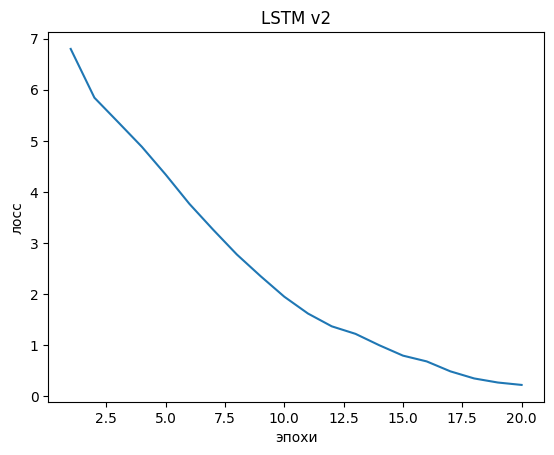

In [17]:
plt.plot(range(1, num_epochs + 1), losses)
plt.xlabel('эпохи')
plt.ylabel('лосс')
plt.title('LSTM v2')
plt.show()

In [18]:
def generate_text(model, start_text, length=50):
    model.eval()
    words = start_text.split()
    inputs = torch.tensor(text_to_sequence(' '.join(words), vocab), dtype=torch.long).unsqueeze(0).to(device)
    generated_text = start_text

    with torch.no_grad():
        for _ in range(length):
            output = model(inputs)
            _, predicted_idx = torch.max(output, dim=1)
            predicted_word = reverse_vocab.get(predicted_idx.item(), "<UNK>")
            generated_text += ' ' + predicted_word

            words.append(predicted_word)
            inputs = torch.tensor(text_to_sequence(' '.join(words[-seq_length:]), vocab), dtype=torch.long).unsqueeze(0).to(device)

    return generated_text

start_text = "сегодня в анекдоте"
generated_text = generate_text(model, start_text)
print(generated_text)

сегодня в анекдоте <UNK> <UNK> в <UNK> состоянии язык <UNK> к <UNK> а не лежит внизу <UNK> рта дождь и ветер так сильно <UNK> <UNK> что она решила не ходить на этих выходных на <UNK> вечеринку бл <UNK> в <UNK> забыл <UNK> теперь вы понимаете про кого была песня замечательный мужик меня <UNK>
